# Imports

# Setup

# Matrices
The general equation is
$$
c_t = \kappa \Delta c - f(n,r,b),
$$
which for CN becomes
\begin{aligned}
    \frac{u_{i,j}^{n+1} + u_{i,j}^{n}}{\Delta t} &= \frac{\kappa}{2\Delta x \Delta y} (
        &u_{i+1,j}^{n+1} + u_{i-1,j}^{n+1} + u_{i,j+1}^{n+1} + u_{i,j-1}^{n+1} - 4u_{i,j}^{n+1}\\
        & & +u_{i+1,j}^{n} + u_{i-1,j}^{n} + u_{i,j+1}^{n} + u_{i,j-1}^{n} - 4u_{i,j}^{n}
    ).
\end{aligned}
Set $n+1$ and $n$ terms on left and right side, respectively. Also, define $\sigma:=\Delta t \kappa /2\Delta x \Delta y$. Then it is
\begin{equation}
    -\sigma (u_{i-1,j}^{n+1} + u_{i,j-1}^{n+1}) + (1+4\sigma) u_{i,j}^{n+1} - \sigma (u_{i+1,j}^{n+1} + u_{i,j+1}^{n+1})
    = \sigma (u_{i-1,j}^{n} + u_{i,j-1}^{n}) - (1+4\sigma) u_{i,j}^{n} + \sigma (u_{i+1,j}^{n} + u_{i,j+1}^{n})
\end{equation}
We see that for the upper left corner of the grid $u_{i-1,j}$ and $u_{i,j-1}$ are outside the grid. That is, $u_{-1,0}$ and $u_{0,-1}$. Same goes for all corners. Along the top and bottom rows and leftmost and rightmost column we are missing $u_{-1,j},u_{n+1,j}, u_{i,-1}, u_{i,n+1}$ respectively. For now we simply compensate this by adjusting the coefficient in front of i,jth term such that the row sum is one. That is, for none missing the coefficient is $1+4\Sigma$ (middle of grid), where one is missing (boundaries, not corners) $1+3\sigma$, and when two are missing (corners) $1+2\sigma$. 

To make the matrix multiplication applicable for the grid we stretch the grid into one vector $Uv = [u_{0,0}, u_{0,1},...,u_{0,m}, u_{1,0}, u_{1,1},...,u_{n-1,m},u_{n,0},..., u_{n,m}]^T$. Also, we need a block matrix composed of four matrices, $A_u, A_d, A_{\pm1}, A_l$ corresponding to top row of grid, interior, $u_{i\pm1,j}$ and bottom row of grid, respectively. They look like this
$$
A_u =
\begin{bmatrix}
    1+2\sigma   & -\sigma   & 0         & \dots     &           & 0  \\
    -\sigma     & 1+3\sigma & -\sigma   & 0         & \dots     &  \vdots \\
    0           &-\sigma    & 1+3\sigma & -\sigma   & 0         &   \\
    \vdots      &           & \ddots    & \ddots    & \ddots    &   \\
                &           &           & -\sigma   & 1+3\sigma & -\sigma    \\
    0           &           &           &           &  -\sigma  & 1+2\sigma   \\
\end{bmatrix} \\ \\ \\

A_d =
\begin{bmatrix}
    1+3\sigma   & -\sigma   & 0         & \dots     &           & 0  \\
    -\sigma     & 1+4\sigma & -\sigma   & 0         & \dots     &  \vdots \\
    0           &-\sigma    & 1+4\sigma & -\sigma   & 0         &   \\
    \vdots      &           & \ddots    & \ddots    & \ddots    &   \\
                &           &           & -\sigma   & 1+4\sigma & -\sigma    \\
    0           &           &           &           &  -\sigma  & 1+3\sigma   \\
\end{bmatrix} \\ \\ \\

A_{\pm1} = diag(-\sigma),\\ A_l = A_u.
$$
Then, the blockmatrix is
$$
A = 
\begin{bmatrix}
A_u         & A_{\pm1}  & 0         & \dots     &           &           & 0 \\
A_{\pm1}    & A_d       & A_{\pm1}  & 0         &           &           & \vdots \\
0           & A_{\pm1}  & A_d       & A_{\pm1}  & 0         &           &   \\
\vdots      &           & \ddots    & \ddots    & \ddots    &           &   \\
            &           &           &           & A_{\pm1}  & A_d       & A_{\pm1}   \\
0           &           &           &           &           & A_{\pm1}  & A_d        \\
\end{bmatrix}
$$
So the equation to solve is $AUv^{n+1} = BUv^n + f(Uv^n)$ where, conveniently, $B=-A$.

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve, inv

In [115]:
# %% 2D
# Units
height = 15e-9  # Height of cleft (15e-9)
radius = 220e-9  # Radius of cleft/membrane (220e-9)
D = 8e-7  # Diffusion coefficient (8e-7)
k1 = 4e6  # Forward reaction coefficient (4e6)
km1 = 5  # Backward reaction coefficient (5)
r0 = 152  # receptors on membrane (1000/(1e-6)^2 * 2*pi*(220e-9))
n0 = 5000  # Neurotransmitters per vesicle pop

#%% Discretization
nx = 51  # Discretization in x 
ny = 51 # Dicretization in y 
dx = height/nx
dy = 2*radius/ny
dt = 1e-2 # dx**2 # TODO scale

#%% scaling
kappa = D*dt # TODO scale?
sigma = kappa / (2*dx*dy)

#%% sparse matrix
offset = [-nx-1, -1, 0, 1, nx+1] # Offset includes A_+-1
vals = [-sigma, -sigma, (1+4)*sigma, -sigma, -sigma]
A = diags(vals, offset, (nx*ny, nx*ny)) # guess this is right shape
Aarr = A.toarray()
np.set_printoptions(linewidth=160)
# print('(n,m)={}\n'
#       'top left of grid and A_d:\nA[0:n, 0:(m+n+1)] = \n{}\n\n'
#       'in the middle:\nA[(n+1):(2*n+1), (m+1):(2*m+1)] = \n{}\n\n'
#       'bottom right of grid:\nAarr[(n**2-n):, (m**2-m):] = \n{}\n\n'
#       ''.format((n,m),Aarr[0:n, 0:(m+n+1)], Aarr[(n+1):(2*n+1), (m+1):(2*m+1)], Aarr[(n**2-n):, (m**2-m):]))


In [116]:
# Change values of blocks of A corr to A_u and A_l
# A_u
offsetU = [-1, 0, 1]
valsU = [-sigma, 1+3*sigma, -sigma]
Au = diags(valsU, offsetU, (nx, nx))
AuMod = csr_matrix(Au)
AuMod[0,0], AuMod[nx-1,nx-1] = (1+2*sigma,1+2*sigma) # add vals for corners

# Add A_u to A
Amod = csr_matrix(A)
Amod[:nx,:ny] = AuMod # add A_u block
Amod[(nx**2-nx):, (nx**2-nx):] = AuMod # Add A_l block  
# print(Amod[:n,:m])
# print(Amod[n,[n,n+1]])

# Correct for left and right boundary
for i in range(nx, nx*ny-ny, nx):
    Amod[i,i-1] = 0 # Left of grid
    Amod[i,i] = 1+3*sigma # First diag
    Amod[i+nx-1,i+nx-1] = 1+3*sigma # Last diag
    Amod[i+nx-1,i+nx] = 0 # Right of grid

    # print('Fixed points:')
    # print((i,i-1), (i,i), (i+n-1,i+n-1), (i+n-1,i+n))

# Amod[(n**2-n):, (n**2-n):] = AuMod # Add A_l block  
Amod[nx-1,nx] = 0 # Fix one fucker
Amod[nx**2-nx,nx**2-nx-1] = 0 # Fix another fucker  
Bmod = -Amod
# print(Amod.toarray())
# print(Bmod.toarray())

In [117]:
# make grid and init state
ma = height*2*radius #membrane area
cFR0 = r0/ma # consentration of free receptors at t0
Uv = np.zeros(nx*ny)
n0 = Uv # Concentration of neurotransmitters. pop not allocated.
r0 = Uv + cFR0 # uniform concentration
b0 = Uv # concentration of bounded receptors
n0[int(nx*ny/2)] = 5000

def f(n, r, b):
    return -k1*n*r + km1*b

timesteps = int(0.2/dt)
n = np.zeros((timesteps, nx*ny))
r = np.zeros((timesteps, nx*ny))
b = np.zeros((timesteps, nx*ny))
n[0,:] = n0
r[0,:] = r0
b[0,:] = b0


In [118]:
#%% run
AmodInv = inv(A)
AB = AmodInv@Bmod
for t in range(timesteps-1):
    n[t+1, :] = AB@n[t, :]
    # n[t+1, :] = spsolve(Amod, Bmod@n[t, :])  # Only diffusion
#     n[t+1, :] = spsolve(Amod, Bmod@n[t, :] + dt*f(n[t, :], r[t, :], b[t, :]))
#     n[t+1, :] = A@n[t, :] + f(n[t, :], r[t, :], b[t, :])
#     r[t+1, :] = dt*f(n[t, :], r[t, :], b[t, :])
#     b[t+1, :] = -dt*f(n[t, :], r[t, :], b[t, :])

c:\Users\kikka\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\kikka\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [110]:
#%% plot
def plot_heatmap(n, C):
    p = C.reshape((n+1, n+1))
    plt.imshow(p, cmap="hot")  # , interpolation="nearest")
    plt.show()


def plot_3D(nx, ny, C):
    x = np.linspace(0, height, nx)
    y = np.linspace(0, radius, ny)
    x, y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.gca(projection="3d")
#     ax.axes.set_zlim3d(0, 1)
    z = C.reshape((nx, ny))
    ax.plot_surface(x, y, z, cmap="viridis")
    plt.show()


# for t in range(0, timesteps, int(timesteps/5)):
#     plot_3D(nx, ny, n[t, :])


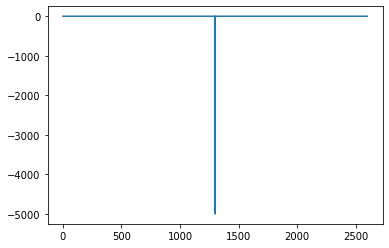

In [112]:
x = np.arange(0,nx*ny,1)
plt.plot(x,n[3,:])